In [14]:
import os
import splitfolders
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [16]:
file_path = 'archive (1)/data' 
output_folder = 'archive (1)/splitted_data'  

In [18]:
# !pip install split_folders
# !pip install opencv-python

In [20]:
def split_dataset(input_folder, output_folder, train_size=0.6, test_size=0.2, val_size=0.2):
    splitfolders.ratio(
        input_folder, 
        output=output_folder, 
        seed=1337, 
        ratio=(train_size, test_size, val_size),
        group_prefix=None
    )

split_dataset(file_path, output_folder)

Copying files: 4189 files [00:09, 441.71 files/s]


In [21]:
train_dir = os.path.join(output_folder, "train")
test_dir = os.path.join(output_folder, "test")
val_dir = os.path.join(output_folder, "val")

def preprocess_data(img_size=(260, 260), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=40,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    val_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, test_generator, val_generator

train_gen, test_gen, val_gen = preprocess_data()

Found 2511 images belonging to 5 classes.
Found 841 images belonging to 5 classes.
Found 836 images belonging to 5 classes.


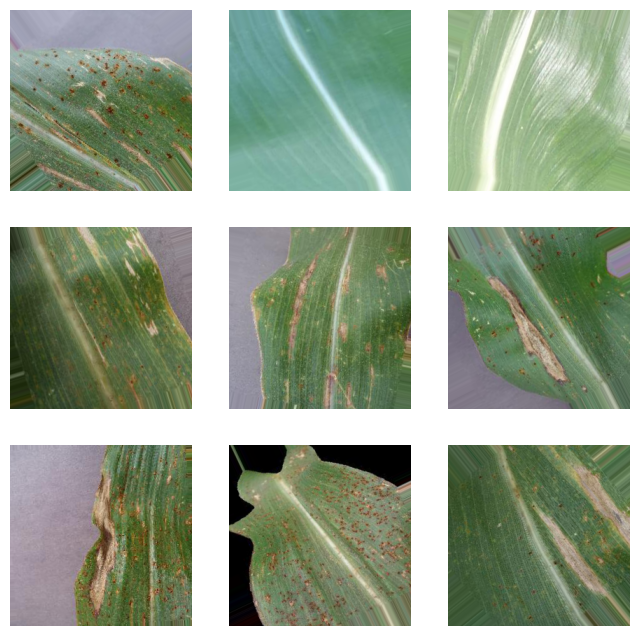

In [22]:
def show_sample_images(generator):
    images, labels = next(generator)  
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

show_sample_images(train_gen)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape=(260, 260, 3), num_classes=len(train_gen.class_indices)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

C:\Users\sakit\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 258, 258, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 129, 129, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 127, 127, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,621 (56.61 MB)

 Trainable params: 14,839,621 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

C:\Users\sakit\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.5492 - loss: 1.0957 - val_accuracy: 0.7679 - val_loss: 0.5379
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8203 - loss: 0.4122 - val_accuracy: 0.8146 - val_loss: 0.4311
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8410 - loss: 0.3686 - val_accuracy: 0.8182 - val_loss: 0.4636
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8617 - loss: 0.3168 - val_accuracy: 0.8409 - val_loss: 0.3812
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8659 - loss: 0.3094 - val_accuracy: 0.8600 - val_loss: 0.3326
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8763 - loss: 0.2915 - val_accuracy: 0.8792 - val_loss: 0.3132
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8885 - loss: 0.2663 - val_accuracy: 0.8804 - val_loss: 0.2750
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8903 - loss: 0.2541 - val_accuracy: 0.8995 - v

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

25/27 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step - accuracy: 0.8704 - loss: 0.3369